# r/MSCS Dataset Cleaning

This notebook cleans two JSONL files scraped from the r/MSCS subreddit:
- `r_MSCS_posts.jsonl` — 18,799 posts (Aug 2023 – Jul 2025)
- `r_MSCS_comments.jsonl` — 133,482 comments (Aug 2023 – Jul 2025)

The data covers graduate CS admissions discussions over approximately two years.

**Cleaning stages:**
1. Load raw data and inspect structure
2. Select relevant columns
3. Remove deleted / removed / empty content
4. Remove bot authors
5. Remove duplicates
6. Normalize text (whitespace, URLs, markdown artifacts)
7. Parse timestamps and filter to valid date range
8. Final summary comparison

In [1]:
import json
import os
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timezone
from pathlib import Path

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 30)

# ── Locate data directory ────────────────────────────────────────────────────
# When a Jupyter server starts from a different folder than this notebook
# (e.g. server root = /home/ayush, notebook at /media/.../598/), Path('.')
# resolves to the server root and the raw JSONL files won't be found.
# This block walks three detection strategies and then os.chdir() so that
# every subsequent relative path in the notebook works correctly.

_SENTINEL = 'data/r_MSCS_posts.jsonl'

def _locate_data_dir() -> Path:
    # 1. CWD — works when nbconvert runs, or when server root == notebook dir
    if (Path('.') / _SENTINEL).exists():
        return Path('.').resolve()
    # 2. Jupyter Lab ≥3 / Notebook ≥7 set JPY_SESSION_NAME to the notebook path
    _nb = os.environ.get('JPY_SESSION_NAME', '')
    if _nb:
        _p = Path(_nb).expanduser().resolve().parent
        if (_p / _SENTINEL).exists():
            return _p
    # 3. The kernel prepends the notebook's directory to sys.path
    for _d in sys.path:
        if _d and (Path(_d) / _SENTINEL).exists():
            return Path(_d).resolve()
    raise FileNotFoundError(
        f"Cannot find '{_SENTINEL}'.\n"
        "Either open this notebook from its own directory, or set DATA_DIR "
        "below to an absolute path pointing at the folder with the JSONL files."
    )

DATA_DIR = _locate_data_dir()
os.chdir(DATA_DIR)
print(f'Data directory : {DATA_DIR}')

POSTS_FILE    = DATA_DIR / 'data/r_MSCS_posts.jsonl'
COMMENTS_FILE = DATA_DIR / 'data/r_MSCS_comments.jsonl'

def load_jsonl(path):
    records = []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if line:
                records.append(json.loads(line))
    return records

print('Loading posts ...')
raw_posts = load_jsonl(POSTS_FILE)
print(f'  {len(raw_posts):,} records loaded')

print('Loading comments ...')
raw_comments = load_jsonl(COMMENTS_FILE)
print(f'  {len(raw_comments):,} records loaded')

Data directory : /media/ayush/F/Coding/598/mscs
Loading posts ...
  18,799 records loaded
Loading comments ...
  133,482 records loaded


---
## Stage 1 — Raw Data Snapshot

In [2]:
# Convert to DataFrames for easier inspection
posts_raw    = pd.DataFrame(raw_posts)
comments_raw = pd.DataFrame(raw_comments)

print('=== POSTS RAW ===')
print(f'Shape : {posts_raw.shape}')
print(f'Columns ({len(posts_raw.columns)}): {list(posts_raw.columns)}')

print('\n=== COMMENTS RAW ===')
print(f'Shape : {comments_raw.shape}')
print(f'Columns ({len(comments_raw.columns)}): {list(comments_raw.columns)}')

=== POSTS RAW ===
Shape : (18799, 119)
Columns (119): ['_meta', 'all_awardings', 'allow_live_comments', 'approved_at_utc', 'approved_by', 'archived', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_is_blocked', 'author_patreon_flair', 'author_premium', 'awarders', 'banned_at_utc', 'banned_by', 'can_gild', 'can_mod_post', 'category', 'clicked', 'content_categories', 'contest_mode', 'created', 'created_utc', 'discussion_type', 'distinguished', 'domain', 'downs', 'edited', 'gilded', 'gildings', 'hidden', 'hide_score', 'id', 'is_created_from_ads_ui', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'likes', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'l

In [3]:
print('--- Posts: first 3 records (selected fields) ---')
posts_raw[['id','author','title','selftext','score','num_comments','created_utc']].head(3)

--- Posts: first 3 records (selected fields) ---


,id,author,title,selftext,score,num_comments,created_utc
0,15f3g0b,08Satan,"EC undergraduate here, is it nearly impossible to get into MS CS in top US universities with my profile?","Hi everyone, I am planning for masters in CS. I am an EC undergrad from India JSS Science and Technology university...",2,16,1690868511
1,15ffeap,han_1206,Profile evaluation for fall 2024,Hey fellow redditors. I'm trying to evaluate my potential uni list to apply for MS in CS (or MCS also works). Here's...,3,18,1690902857
2,15fgn9t,igar234,What transcripts to send to universities during the application?,"Hello, I had applied to ASU yesterday, 31st July, 1 day before the deadline, and it says there are pending items in ...",1,2,1690905650


In [4]:
print('--- Comments: first 3 records (selected fields) ---')
comments_raw[['id','author','body','score','link_id','parent_id','created_utc']].head(3)

--- Comments: first 3 records (selected fields) ---


,id,author,body,score,link_id,parent_id,created_utc
0,jua0ois,_PandaBear,I would always go for US. I know it has things like H1B and all but it comes with a lot more benefits too if you get...,5,t3_15edup5,t3_15edup5,1690849046
1,juadbmb,fall2023mscs,Doesn't matter did IT in undergrad now going for MSCS,2,t3_15ea1qx,t3_15ea1qx,1690854636
2,juaiyg0,admit_2024,Yeah reading posts about last cycle being brutal makes me anxious. Thanks a lot,2,t3_15eczio,t1_ju6z297,1690857236


In [5]:
# Null / missing value overview
print('=== Posts: null counts (top 20 columns with nulls) ===')
null_posts = posts_raw.isnull().sum().sort_values(ascending=False)
display(null_posts[null_posts > 0].head(20).to_frame('null_count'))

print('\n=== Comments: null counts (top 20 columns with nulls) ===')
null_comments = comments_raw.isnull().sum().sort_values(ascending=False)
display(null_comments[null_comments > 0].head(20).to_frame('null_count'))

=== Posts: null counts (top 20 columns with nulls) ===


,null_count
mod_reason_by,18799
removal_reason,18799
banned_by,18799
banned_at_utc,18799
likes,18799
mod_note,18799
mod_reason_title,18799
category,18799
content_categories,18799
author_flair_css_class,18799



=== Comments: null counts (top 20 columns with nulls) ===


,null_count
top_awarded_type,133482
approved_at_utc,133482
approved_by,133482
associated_award,133482
collapsed_because_crowd_control,133482
likes,133482
author_flair_css_class,133482
mod_note,133482
mod_reason_by,133482
banned_by,133482


---
## Stage 2 — Select Relevant Columns

Most Reddit API fields are irrelevant for NLP / social-science analysis of CS admissions discussions.
We keep only the fields needed for content analysis, temporal analysis, and author-level analysis.

In [6]:
POST_COLS = [
    'id',
    'author',
    'title',
    'selftext',
    'score',
    'upvote_ratio',
    'num_comments',
    'link_flair_text',
    'created_utc',
    'permalink',
]

COMMENT_COLS = [
    'id',
    'author',
    'body',
    'score',
    'link_id',      # post this comment belongs to  (t3_<post_id>)
    'parent_id',    # immediate parent              (t1_<comment_id> or t3_<post_id>)
    'created_utc',
    'permalink',
    'is_submitter', # True if the commenter is also the post author
]

posts    = posts_raw[POST_COLS].copy()
comments = comments_raw[COMMENT_COLS].copy()

print(f'Posts:    {posts_raw.shape[1]} columns → {posts.shape[1]} columns')
print(f'Comments: {comments_raw.shape[1]} columns → {comments.shape[1]} columns')

print('\nPosts columns kept:', POST_COLS)
print('Comments columns kept:', COMMENT_COLS)

Posts:    119 columns → 10 columns
Comments: 74 columns → 9 columns

Posts columns kept: ['id', 'author', 'title', 'selftext', 'score', 'upvote_ratio', 'num_comments', 'link_flair_text', 'created_utc', 'permalink']
Comments columns kept: ['id', 'author', 'body', 'score', 'link_id', 'parent_id', 'created_utc', 'permalink', 'is_submitter']


---
## Stage 3 — Remove Deleted / Removed / Empty Content

In [7]:
SENTINEL_VALUES = {'[deleted]', '[removed]', '[deleted by user]'}

def count_content_issues(df, text_col):
    deleted = df[text_col].isin(SENTINEL_VALUES).sum()
    empty   = (df[text_col].fillna('').str.strip() == '').sum()
    return deleted, empty

p_del, p_emp = count_content_issues(posts,    'selftext')
c_del, c_emp = count_content_issues(comments, 'body')

print('BEFORE removing bad content:')
print(f'  Posts    — total: {len(posts):>7,} | sentinel (deleted/removed): {p_del:,} | empty selftext: {p_emp:,}')
print(f'  Comments — total: {len(comments):>7,} | sentinel (deleted/removed): {c_del:,} | empty body:     {c_emp:,}')

BEFORE removing bad content:
  Posts    — total:  18,799 | sentinel (deleted/removed): 390 | empty selftext: 1,168
  Comments — total: 133,482 | sentinel (deleted/removed): 1,422 | empty body:     0


In [8]:
# Posts: drop rows where selftext is a sentinel value.
# NOTE: empty selftext is KEPT — many legitimate posts are title-only (link posts, polls).
posts_step3 = posts[~posts['selftext'].isin(SENTINEL_VALUES)].copy()
posts_step3['selftext'] = posts_step3['selftext'].fillna('')

# Comments: a comment with no body is useless — drop all sentinel and truly empty rows.
mask_bad_comments = (
    comments['body'].isin(SENTINEL_VALUES) |
    (comments['body'].fillna('').str.strip() == '')
)
comments_step3 = comments[~mask_bad_comments].copy()

print('AFTER removing bad content:')
print(f'  Posts    — {len(posts):>7,} → {len(posts_step3):>7,}   (removed {len(posts)-len(posts_step3):,})')
print(f'  Comments — {len(comments):>7,} → {len(comments_step3):>7,}   (removed {len(comments)-len(comments_step3):,})')

AFTER removing bad content:
  Posts    —  18,799 →  18,409   (removed 390)
  Comments — 133,482 → 132,060   (removed 1,422)


---
## Stage 4 — Remove Bot Authors

In [9]:
# Known bots identified by explicit names — covers accounts whose names
# do NOT follow the "-bot" / "_bot" suffix pattern (e.g. AutoModerator, robot-zz, botmansj).
KNOWN_BOTS = {
    'AutoModerator',
    'Paid-Not-Payed-Bot',
    'exclaim_bot',
    'robot-zz',
    'ironrobot10',
    'botmansj',
    'MechanicalBot1234',
    'jjjimbotron',
    'SnooRobots8889',
}

# Heuristic: match "bot" at the END of the username (with optional trailing separator/digits).
# The negative lookbehind (?<!o) prevents matching the "bot" inside "robot",
# which is a common substring in perfectly-human usernames like:
#   vivaciousrobot, neverarobot333, wannabearoboticist, roboticninjafapper.
#
# This also avoids the old false-positives caused by plain substring matching:
#   "both"   → Both_Alps1067, Both_Particular_4128, EntertainmentBoth923, ...
#   "bottle" → EmbarrassedBottle411, IllustriousBottle524, VatrBottle, ...
#   "bother" → Forsaken-Bother-4481
#
# Correct matches (real bots):
#   RemindMeBot, sneakpeekbot, gcp_updates_bot, tiny_smile_bot,
#   alphabet_order_bot, Careless-Working-Bot, friendlybot_, psychoticbot, ...
BOT_SUFFIX_RE = re.compile(r'(?<!o)bot[_\-\d]*$', re.IGNORECASE)

def is_bot(username: str) -> bool:
    if pd.isna(username):
        return False
    if username in KNOWN_BOTS:
        return True
    return bool(BOT_SUFFIX_RE.search(username))

# Identify bots
posts_bot_mask    = posts_step3['author'].apply(is_bot)
comments_bot_mask = comments_step3['author'].apply(is_bot)

print('Bot authors found in posts:')
print(' ', sorted(posts_step3.loc[posts_bot_mask, 'author'].unique()))
print(f'  Count: {posts_bot_mask.sum():,} posts')

print('\nBot authors found in comments:')
print(' ', sorted(comments_step3.loc[comments_bot_mask, 'author'].unique()))
print(f'  Count: {comments_bot_mask.sum():,} comments')

Bot authors found in posts:
  ['AutoModerator', 'MechanicalBot1234', 'SnooRobots8889', 'botmansj', 'ironrobot10', 'jjjimbotron', 'robot-zz']
  Count: 37 posts

Bot authors found in comments:
  ['AmputatorBot', 'Booty_Warrior_bot', 'Careless-Working-Bot', 'LearnDifferenceBot', 'LuckyNumber-Bot', 'Paid-Not-Payed-Bot', 'RemindMeBot', 'SnooRobots8889', 'alphabet_order_bot', 'exclaim_bot', 'friendlybot_', 'gcp_updates_bot', 'ironrobot10', 'psychoticbot', 'robot-zz', 's_copypasta_bot', 'sneakpeekbot', 'tiny_smile_bot']
  Count: 270 comments


In [10]:
posts_step4    = posts_step3[~posts_bot_mask].copy()
comments_step4 = comments_step3[~comments_bot_mask].copy()

print('AFTER removing bot authors:')
print(f'  Posts    — {len(posts_step3):>7,} → {len(posts_step4):>7,}   (removed {len(posts_step3)-len(posts_step4):,})')
print(f'  Comments — {len(comments_step3):>7,} → {len(comments_step4):>7,}   (removed {len(comments_step3)-len(comments_step4):,})')

AFTER removing bot authors:
  Posts    —  18,409 →  18,372   (removed 37)
  Comments — 132,060 → 131,790   (removed 270)


---
## Stage 5 — Remove Duplicates

In [11]:
p_dups = posts_step4.duplicated(subset='id').sum()
c_dups = comments_step4.duplicated(subset='id').sum()
print(f'Duplicate post IDs:    {p_dups:,}')
print(f'Duplicate comment IDs: {c_dups:,}')

posts_step5    = posts_step4.drop_duplicates(subset='id').copy()
comments_step5 = comments_step4.drop_duplicates(subset='id').copy()

print(f'\nAFTER deduplication:')
print(f'  Posts    — {len(posts_step4):>7,} → {len(posts_step5):>7,}')
print(f'  Comments — {len(comments_step4):>7,} → {len(comments_step5):>7,}')

Duplicate post IDs:    0
Duplicate comment IDs: 0

AFTER deduplication:
  Posts    —  18,372 →  18,372
  Comments — 131,790 → 131,790


---
## Stage 6 — Text Normalization

Operations applied to `selftext` (posts) and `body` (comments):

| # | Operation | Rationale |
|---|-----------|----------|
| 1 | Strip markdown link syntax `[text](url)` → `text` | URLs add noise; anchor text keeps semantics |
| 2 | Remove bare URLs | Not useful for semantic analysis |
| 3 | Collapse excessive whitespace / newlines | Normalize formatting |
| 4 | Strip leading/trailing whitespace | Housekeeping |

In [12]:
URL_RE    = re.compile(r'https?://\S+')
MD_LINK   = re.compile(r'\[([^\]]+)\]\(https?://[^)]+\)')   # [text](url)
MD_LINK2  = re.compile(r'\[([^\]]+)\]\([^)]+\)')             # [text](anything)
NBSP      = re.compile(r'[\xa0\u200b\u200c\u200d\ufeff]')    # non-breaking / zero-width spaces
MULTI_NL  = re.compile(r'\n{3,}')                             # 3+ consecutive newlines → 2
MULTI_SP  = re.compile(r'[ \t]{2,}')                          # multiple spaces/tabs → single space

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = MD_LINK.sub(r'\1', text)       # [text](url) → text
    text = MD_LINK2.sub(r'\1', text)      # [text](...) → text
    text = URL_RE.sub('', text)           # bare URLs
    text = NBSP.sub(' ', text)            # special whitespace
    text = MULTI_NL.sub('\n\n', text)    # collapse newlines
    text = MULTI_SP.sub(' ', text)        # collapse spaces
    return text.strip()

# Show a before/after example
ex = posts_step5['selftext'].iloc[1]
print('--- BEFORE normalization (first 400 chars) ---')
print(repr(ex[:400]))
print()
print('--- AFTER normalization (first 400 chars) ---')
print(repr(normalize_text(ex)[:400]))

--- BEFORE normalization (first 400 chars) ---
"Hey fellow redditors. I'm trying to evaluate my potential uni list to apply for MS in CS (or MCS also works). Here's my profile:\n\nUG: B.Tech in CS from PES University, India (Tier 2). Private university. Graduated 2023\n\nTarget Major: MSCS/MCS. No specialization as such.\n\nGPA: 8.29/10\n\nGRE: yet to give, but getting 316 in mock(V: 149, Q: 167, AWA: 3)\n\nTOEFL: yet to give\n\nResearch papers: 2 publishe"

--- AFTER normalization (first 400 chars) ---
"Hey fellow redditors. I'm trying to evaluate my potential uni list to apply for MS in CS (or MCS also works). Here's my profile:\n\nUG: B.Tech in CS from PES University, India (Tier 2). Private university. Graduated 2023\n\nTarget Major: MSCS/MCS. No specialization as such.\n\nGPA: 8.29/10\n\nGRE: yet to give, but getting 316 in mock(V: 149, Q: 167, AWA: 3)\n\nTOEFL: yet to give\n\nResearch papers: 2 publishe"


In [13]:
posts_step6    = posts_step5.copy()
comments_step6 = comments_step5.copy()

posts_step6['selftext'] = posts_step6['selftext'].apply(normalize_text)
posts_step6['title']    = posts_step6['title'].apply(normalize_text)
comments_step6['body']  = comments_step6['body'].apply(normalize_text)

# After normalization some texts may have become empty — drop them
posts_step6    = posts_step6[posts_step6['title'].str.len() > 0].copy()
comments_step6 = comments_step6[comments_step6['body'].str.len() > 0].copy()

print('AFTER text normalization (post-cleanup):')
print(f'  Posts    — {len(posts_step5):>7,} → {len(posts_step6):>7,}')
print(f'  Comments — {len(comments_step5):>7,} → {len(comments_step6):>7,}')

# Word count summary on posts
posts_step6['word_count'] = posts_step6['selftext'].str.split().str.len().fillna(0).astype(int)
print(f'\nPost selftext word count stats:')
print(posts_step6['word_count'].describe().to_string())

AFTER text normalization (post-cleanup):
  Posts    —  18,372 →  18,372
  Comments — 131,790 → 131,427

Post selftext word count stats:
count    18372.000000
mean        77.278794
std         93.741162
min          0.000000
25%         19.000000
50%         51.000000
75%        108.000000
max       4168.000000


---
## Stage 7 — Final Cleaned Datasets

In [14]:
# Convert Unix timestamps to datetime
posts_step6['created_dt'] = pd.to_datetime(posts_step6['created_utc'], unit='s', utc=True)
comments_step6['created_dt'] = pd.to_datetime(comments_step6['created_utc'], unit='s', utc=True)

# Define date range: Aug 2023 - Jul 2025
start_date = pd.to_datetime('2023-08-01', utc=True)
end_date = pd.to_datetime('2025-07-31 23:59:59', utc=True)

# Filter by date range
posts_step7 = posts_step6[(posts_step6['created_dt'] >= start_date) & (posts_step6['created_dt'] <= end_date)].copy()
comments_step7 = comments_step6[(comments_step6['created_dt'] >= start_date) & (comments_step6['created_dt'] <= end_date)].copy()

print('AFTER date filter (Aug 2023 - Jul 2025):')
print(f'  Posts    — {len(posts_step6):>7,} → {len(posts_step7):>7,}   (removed {len(posts_step6)-len(posts_step7):,})')
print(f'  Comments — {len(comments_step6):>7,} → {len(comments_step7):>7,}   (removed {len(comments_step6)-len(comments_step7):,})')

AFTER date filter (Aug 2023 - Jul 2025):
  Posts    —  18,372 →  18,372   (removed 0)
  Comments — 131,427 → 131,427   (removed 0)


In [15]:
posts_clean    = posts_step7.reset_index(drop=True)
comments_clean = comments_step7.reset_index(drop=True)

print('=== POSTS CLEAN ===')
print(f'Shape: {posts_clean.shape}')
posts_clean[['id','author','title','selftext','score','num_comments','created_dt']].head(3)

=== POSTS CLEAN ===
Shape: (18372, 12)


,id,author,title,selftext,score,num_comments,created_dt
0,15f3g0b,08Satan,"EC undergraduate here, is it nearly impossible to get into MS CS in top US universities with my profile?","Hi everyone, I am planning for masters in CS. I am an EC undergrad from India JSS Science and Technology university,...",2,16,2023-08-01 05:41:51+00:00
1,15ffeap,han_1206,Profile evaluation for fall 2024,Hey fellow redditors. I'm trying to evaluate my potential uni list to apply for MS in CS (or MCS also works). Here's...,3,18,2023-08-01 15:14:17+00:00
2,15fgn9t,igar234,What transcripts to send to universities during the application?,"Hello, I had applied to ASU yesterday, 31st July, 1 day before the deadline, and it says there are pending items in ...",1,2,2023-08-01 16:00:50+00:00


In [16]:
print('=== COMMENTS CLEAN ===')
print(f'Shape: {comments_clean.shape}')
comments_clean[['id','author','body','score','link_id','created_dt']].head(3)

=== COMMENTS CLEAN ===
Shape: (131427, 10)


,id,author,body,score,link_id,created_dt
0,jua0ois,_PandaBear,I would always go for US. I know it has things like H1B and all but it comes with a lot more benefits too if you get...,5,t3_15edup5,2023-08-01 00:17:26+00:00
1,juadbmb,fall2023mscs,Doesn't matter did IT in undergrad now going for MSCS,2,t3_15ea1qx,2023-08-01 01:50:36+00:00
2,juaiyg0,admit_2024,Yeah reading posts about last cycle being brutal makes me anxious. Thanks a lot,2,t3_15eczio,2023-08-01 02:33:56+00:00


---
## Before vs. After Summary

In [17]:
summary = pd.DataFrame({
    'Stage': [
        '0 — Raw',
        '2 — Column selection',
        '3 — Remove deleted/removed/empty',
        '4 — Remove bots',
        '5 — Deduplicate',
        '6 — Normalize text',
        '7 — Date filter',
    ],
    'Posts': [
        len(posts_raw),
        len(posts),
        len(posts_step3),
        len(posts_step4),
        len(posts_step5),
        len(posts_step6),
        len(posts_step7),
    ],
    'Comments': [
        len(comments_raw),
        len(comments),
        len(comments_step3),
        len(comments_step4),
        len(comments_step5),
        len(comments_step6),
        len(comments_step7),
    ],
})

summary['Posts removed (cum.)']    = summary['Posts'].iloc[0]    - summary['Posts']
summary['Comments removed (cum.)'] = summary['Comments'].iloc[0] - summary['Comments']
display(summary)

,Stage,Posts,Comments,Posts removed (cum.),Comments removed (cum.)
0,0 — Raw,18799,133482,0,0
1,2 — Column selection,18799,133482,0,0
2,3 — Remove deleted/removed/empty,18409,132060,390,1422
3,4 — Remove bots,18372,131790,427,1692
4,5 — Deduplicate,18372,131790,427,1692
5,6 — Normalize text,18372,131427,427,2055
6,7 — Date filter,18372,131427,427,2055


/tmp/ipykernel_258834/568861840.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stages, rotation=30, ha='right', fontsize=8)
/tmp/ipykernel_258834/568861840.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stages, rotation=30, ha='right', fontsize=8)


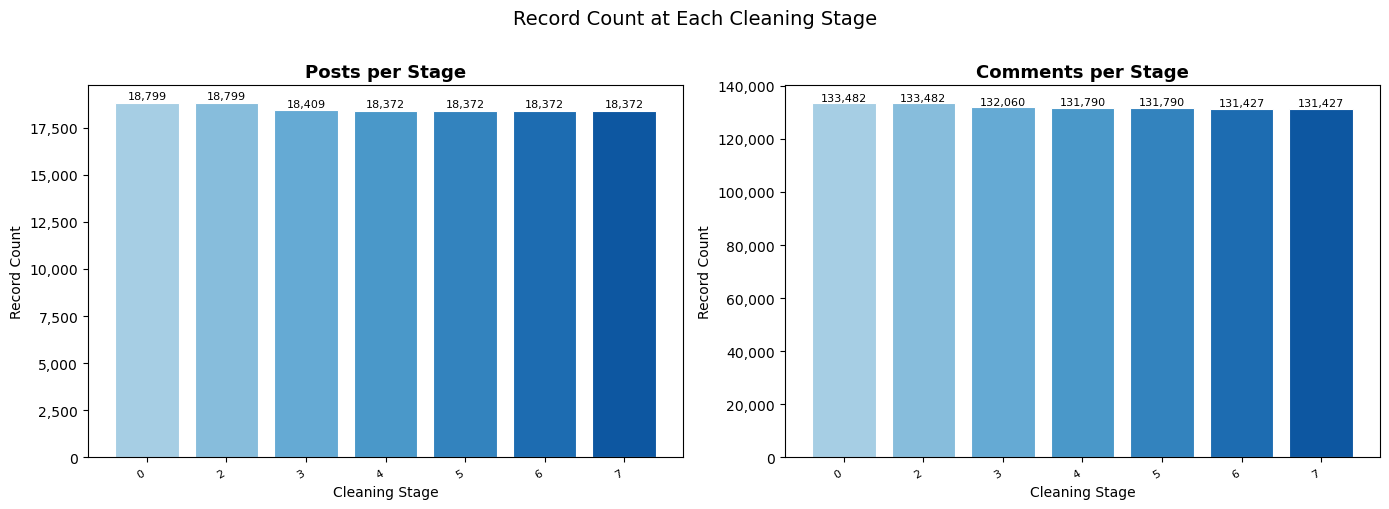

Saved: outputs/cleaning_stages.png


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
stages = [s.split('—')[0].strip() for s in summary['Stage']]

colors = plt.cm.Blues(np.linspace(0.35, 0.85, len(summary)))

for ax, col, title in zip(axes, ['Posts', 'Comments'], ['Posts per Stage', 'Comments per Stage']):
    bars = ax.bar(stages, summary[col], color=colors, edgecolor='white', linewidth=0.8)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Cleaning Stage')
    ax.set_ylabel('Record Count')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xticklabels(stages, rotation=30, ha='right', fontsize=8)
    for bar, val in zip(bars, summary[col]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{val:,}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Record Count at Each Cleaning Stage', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('outputs/cleaning_stages.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: outputs/cleaning_stages.png')

/tmp/ipykernel_258834/584721114.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts_clean['month'] = posts_clean['created_dt'].dt.to_period('M')


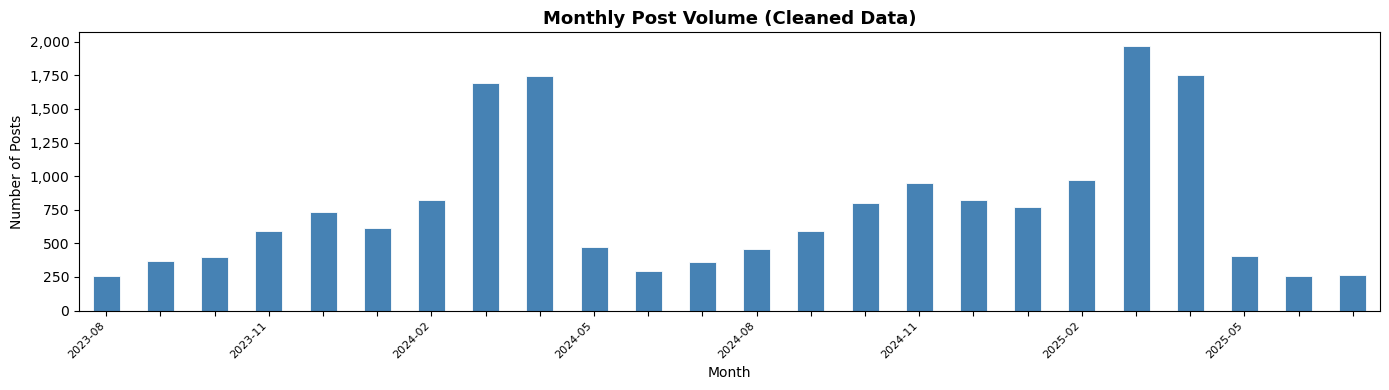

Saved: outputs/monthly_posts.png


In [19]:
# Post activity over time (monthly)
posts_clean['month'] = posts_clean['created_dt'].dt.to_period('M')
monthly = posts_clean.groupby('month').size()

fig, ax = plt.subplots(figsize=(14, 4))
monthly.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white', linewidth=0.6)
ax.set_title('Monthly Post Volume (Cleaned Data)', fontsize=13, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Posts')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
tick_labels = monthly.index.astype(str)
ax.set_xticklabels(
    [lbl if i % 3 == 0 else '' for i, lbl in enumerate(tick_labels)],
    rotation=45, ha='right', fontsize=8
)
plt.tight_layout()
plt.savefig('outputs/monthly_posts.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: outputs/monthly_posts.png')

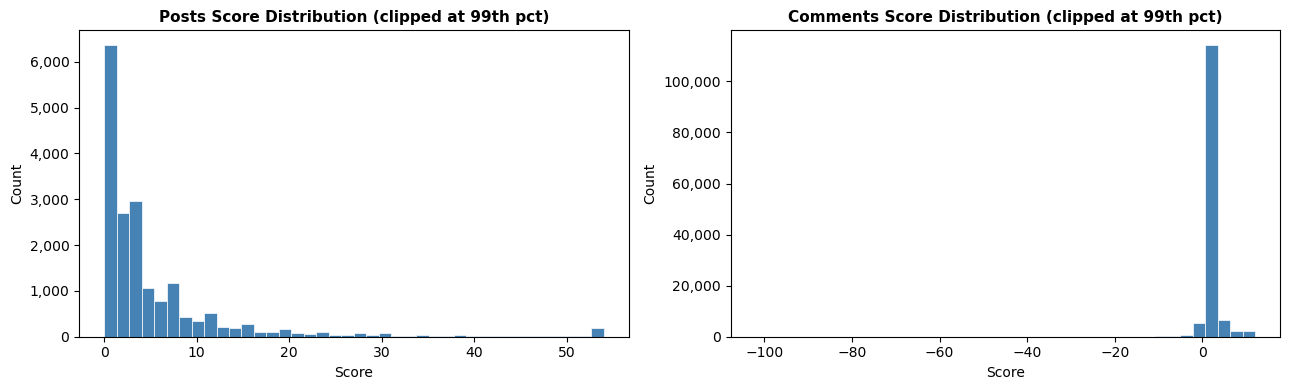

Saved: outputs/score_distribution.png


In [20]:
# Score distribution
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

for ax, df, col, label in [
    (axes[0], posts_clean,    'score', 'Posts'),
    (axes[1], comments_clean, 'score', 'Comments'),
]:
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    ax.hist(clipped, bins=40, color='steelblue', edgecolor='white', linewidth=0.5)
    ax.set_title(f'{label} Score Distribution (clipped at 99th pct)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.savefig('outputs/score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: outputs/score_distribution.png')

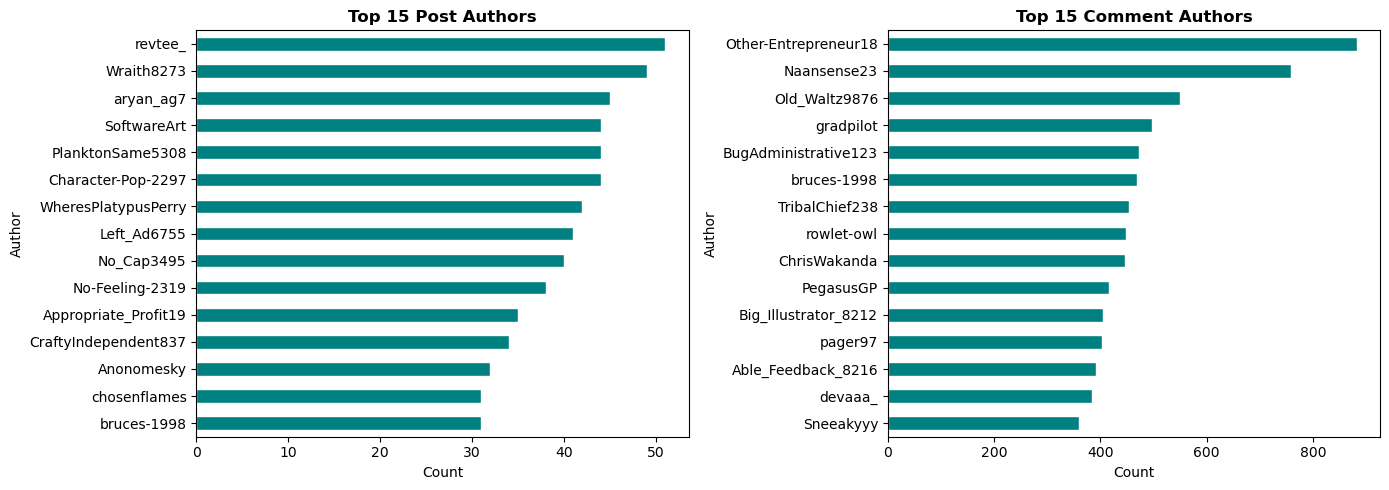

Saved: outputs/top_authors.png


In [21]:
# Author activity
top_post_authors    = posts_clean['author'].value_counts().head(15)
top_comment_authors = comments_clean['author'].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, series, title in [
    (axes[0], top_post_authors,    'Top 15 Post Authors'),
    (axes[1], top_comment_authors, 'Top 15 Comment Authors'),
]:
    series.sort_values().plot(kind='barh', ax=ax, color='teal', edgecolor='white')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Count')
    ax.set_ylabel('Author')

plt.tight_layout()
plt.savefig('outputs/top_authors.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: outputs/top_authors.png')

---
## Stage 8 — Save Cleaned Datasets

Outputs consumed by `analyze_mscs_data.ipynb`:
- `r_MSCS_posts_clean.jsonl` — cleaned posts
- `r_MSCS_comments_clean.jsonl` — cleaned comments
- `r_MSCS_cleaning_stats.json` — per-stage record counts (used for noise pie chart)

In [22]:
import json as _json, math as _math, numpy as _np

# pandas' to_json uses ujson which hits a recursion limit on long text strings.
# Use stdlib json with a small encoder to handle numpy scalars and NaN → null.
class _Encoder(_json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, _np.integer):  return int(obj)
        if isinstance(obj, _np.floating): return None if _math.isnan(float(obj)) else float(obj)
        if isinstance(obj, float) and _math.isnan(obj): return None
        return super().default(obj)

def _save_jsonl(df, path, drop_cols):
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    with open(path, 'w', encoding='utf-8') as f:
        for rec in df.to_dict('records'):
            f.write(_json.dumps(rec, cls=_Encoder, ensure_ascii=False) + '\n')

# Drop created_dt (reconstructed from created_utc on load) and month (Period type —
# not JSON serialisable, and trivially re-derived from created_utc in analyze notebook).
_save_jsonl(posts_clean,    'data/r_MSCS_posts_clean.jsonl',    drop_cols=['created_dt', 'month'])
_save_jsonl(comments_clean, 'data/r_MSCS_comments_clean.jsonl', drop_cols=['created_dt', 'month'])

_json.dump(
    {
        'posts': {
            'n_raw':     len(posts_raw),
            'n_deleted': len(posts_raw)   - len(posts_step3),
            'n_bots':    len(posts_step3) - len(posts_step4),
            'n_clean':   len(posts_clean),
        },
        'comments': {
            'n_raw':     len(comments_raw),
            'n_deleted': len(comments_raw)   - len(comments_step3),
            'n_bots':    len(comments_step3) - len(comments_step4),
            'n_clean':   len(comments_clean),
        },
    },
    open('data/r_MSCS_cleaning_stats.json', 'w'),
    indent=2,
)

print(f"r_MSCS_posts_clean.jsonl      — {len(posts_clean):,} rows")
print(f"r_MSCS_comments_clean.jsonl   — {len(comments_clean):,} rows")
print("r_MSCS_cleaning_stats.json    — per-stage dropout counts")

r_MSCS_posts_clean.jsonl      — 18,372 rows
r_MSCS_comments_clean.jsonl   — 131,427 rows
r_MSCS_cleaning_stats.json    — per-stage dropout counts
